# Differential expression anlaysis of the TCGA breast cancer set

First we retrieve the breast cancer RNAseq data as well as the clinical classification of the sets from cbioportal.org. 

The gene expresion data is stored in the [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) `brca`, and the adherent clinical information of the cancers and their patients is stored in the [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) `brca_clin`. It can be woth exploring these data structures.  


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    ![ ! -f "dsbook/README.md" ] && git clone https://github.com/statisticalbiotechnology/dsbook.git
    my_path = "dsbook/dsbook/common/"
else:
    my_path = "../common/"
sys.path.append(my_path) # Read local modules for tcga access and qvalue calculations
import load_tcga as tcga
import qvalue 

brca = tcga.get_expression_data(my_path + "../data/brca_tcga_pub2015.tar.gz", 'https://cbioportal-datahub.s3.amazonaws.com/brca_tcga_pub2015.tar.gz',"data_mrna_seq_v2_rsem.txt")
brca_clin = tcga.get_clinical_data(my_path + "../data/brca_tcga_pub2015.tar.gz", 'https://cbioportal-datahub.s3.amazonaws.com/brca_tcga_pub2015.tar.gz',"data_clinical_sample.txt")


File extracted to ../data/brca_tcga_pub2015
File extracted to ../data/brca_tcga_pub2015


Before any further analysis we clean our data. This includes removal of genes where no transcripts were found for any of the samples , i.e. their values are either [NaN](https://en.wikipedia.org/wiki/NaN) or zero. 

The data is also log transformed. It is generally assumed that expression values follow a log-normal distribution, and hence the log transformation implies that the new values follow a nomal distribution.

In [2]:
brca.dropna(axis=0, how='any', inplace=True)
brca = brca.loc[~(brca<=0.0).any(axis=1)]
brca = pd.DataFrame(data=np.log2(brca),index=brca.index,columns=brca.columns)

We can get an overview of the expression data, i.e differnt characterizations of the tumors from other sources (patient file, histological analysis etc) than the expression data:

In [3]:
brca

,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,TCGA-A1-A0SN-01,...,TCGA-LL-A5YM-01,TCGA-LL-A5YN-01,TCGA-LL-A5YO-01,TCGA-LL-A5YP-01,TCGA-LQ-A4E4-01,TCGA-MS-A51U-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
HMGB1P1,6.862786,5.913201,7.258756,7.141528,6.318322,5.989800,7.075461,10.128243,6.900577,6.571219,...,6.662298,6.648297,8.121858,7.689562,6.870735,7.235377,6.849722,7.307063,6.961539,6.732642
LOC155060,8.128052,6.387132,6.223071,8.296679,6.580528,7.226836,5.992061,7.381276,6.336428,6.760258,...,7.032748,8.520790,7.373054,6.700139,8.263093,9.077958,8.401726,7.719361,8.335920,9.115184
HSPB1P1,5.449515,7.826203,8.227829,8.110198,6.986008,7.996865,9.313161,6.095703,7.521303,8.912048,...,11.926292,9.389839,8.576146,8.456419,7.290927,7.765053,8.651058,7.933979,10.153871,10.070840
GTPBP6,8.616132,8.083619,8.895371,9.538594,8.465846,8.730170,8.611165,8.370326,8.954813,9.254954,...,10.601717,10.453578,10.685847,10.133098,8.878949,9.282737,9.881552,8.969242,9.087300,9.781890
A1BG,5.620563,7.152768,7.591106,8.348814,7.494444,7.005119,7.825150,6.437021,8.264413,6.452506,...,10.557569,8.821466,8.207272,7.087837,8.962278,8.502185,5.679393,7.695365,8.060956,8.721849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,10.414229,9.761690,9.907780,9.783369,10.402201,9.932282,10.093600,10.431197,10.461518,9.406503,...,8.029939,8.735835,9.524218,9.022067,9.711410,9.745021,9.308973,8.904128,9.416144,9.477514
ZYX,12.594962,11.797529,11.554500,12.383563,12.415996,12.140607,11.566101,9.207597,12.158002,11.505789,...,12.404470,12.495560,12.714737,13.491160,11.410198,12.267554,12.023571,12.692872,12.348940,12.276578
ZZEF1,10.915356,10.320764,9.855441,9.867816,10.358420,9.980989,9.904470,10.812922,10.207563,10.812135,...,8.524975,9.913596,10.200806,10.172626,10.285172,11.111679,10.289877,9.342848,10.460192,10.005446


and the clinical data:

In [4]:
brca_clin

SAMPLE_ID,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,TCGA-A1-A0SN-01,...,TCGA-LL-A5YM-01,TCGA-LL-A5YN-01,TCGA-LL-A5YO-01,TCGA-LL-A5YP-01,TCGA-LQ-A4E4-01,TCGA-MS-A51U-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01
PATIENT_ID,TCGA-A1-A0SB,TCGA-A1-A0SD,TCGA-A1-A0SE,TCGA-A1-A0SF,TCGA-A1-A0SH,TCGA-A1-A0SI,TCGA-A1-A0SJ,TCGA-A1-A0SK,TCGA-A1-A0SM,TCGA-A1-A0SN,...,TCGA-LL-A5YM,TCGA-LL-A5YN,TCGA-LL-A5YO,TCGA-LL-A5YP,TCGA-LQ-A4E4,TCGA-MS-A51U,TCGA-OL-A66H,TCGA-OL-A66I,TCGA-OL-A66J,TCGA-OL-A66K
OTHER_SAMPLE_ID,f66358d4-9319-4c23-983d-ab5056daacf1,81f193d9-ad19-43c2-b89f-54003a8d133e,2fd1998c-1ea4-42eb-84b9-db352da9cf25,f4d51ca6-89a6-4571-ae8d-0fad7dde4452,08044da0-8cb7-4bf7-bbb6-b80be4fddd8c,c5181ae5-bd05-459f-920d-26bd31bd9088,9ec60572-39e4-4a0d-b157-cf0ec726fb1d,dbd8fda0-bdf2-40f0-80b6-daef5ebf9c97,289f5433-4834-401f-9361-efc8e883e630,62d2a36e-feb1-4084-8111-7ea38a4e3049,...,CF5FDA71-8FBA-43FC-91F3-E4BAA36571DD,97AD1ECF-7643-461F-B9A2-1AC953825895,2B7230C7-0182-4417-9861-03672629D98D,3DC0BC4F-6863-4297-8915-F29E1AA25D26,8C8D4BD4-3AA9-4AD1-9715-2376EE540A0C,764A5732-0B44-4CBE-93F2-7B84FD7D81A1,31E39E5F-AF9C-4F34-B065-8363CF9DF39C,2B8C960A-3E9A-49BF-8329-7D322DA90326,1889A2AF-AE25-41EC-8A6D-0EC5C5B852CB,796B90A8-99D6-4102-81A0-96C6954E9F26
DAYS_TO_COLLECTION,764,1697,1672,1648,1305,1267,1399,1164,1115,1091,...,131,41,47,29,414,129,441,1715,1645,981
IS_FFPE,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,...,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO
OCT_EMBEDDED,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,...,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CANCER_TYPE_DETAILED,Invasive Breast Carcinoma,Breast Invasive Ductal Carcinoma,Breast Invasive Lobular Carcinoma,Breast Invasive Ductal Carcinoma,Breast Mixed Ductal and Lobular Carcinoma,Breast Invasive Ductal Carcinoma,Breast Invasive Ductal Carcinoma,Invasive Breast Carcinoma,Breast Invasive Ductal Carcinoma,Breast Invasive Ductal Carcinoma,...,Breast Invasive Ductal Carcinoma,Breast Invasive Ductal Carcinoma,Breast Invasive Ductal Carcinoma,Breast Invasive Ductal Carcinoma,Breast Invasive Lobular Carcinoma,Breast Invasive Lobular Carcinoma,Invasive Breast Carcinoma,Breast Invasive Ductal Carcinoma,Breast Mixed Ductal and Lobular Carcinoma,Breast Invasive Lobular Carcinoma
ONCOTREE_CODE,BRCA,IDC,ILC,IDC,MDLC,IDC,IDC,BRCA,IDC,IDC,...,IDC,IDC,IDC,IDC,ILC,ILC,BRCA,IDC,MDLC,ILC
SAMPLE_TYPE,Primary,Primary,Primary,Primary,Primary,Primary,Primary,Primary,Primary,Primary,...,Primary,Primary,Primary,Primary,Primary,Primary,Primary,Primary,Primary,Primary
SOMATIC_STATUS,Matched,Matched,Matched,Matched,Matched,Matched,Matched,Matched,Matched,Matched,...,Matched,Matched,Matched,Matched,Matched,Matched,Matched,Matched,Matched,Matched


### Differential expression analysis

The goal of the excercise is to determine which genes that are differentially expressed in so called tripple negative cancers as compared to other cancers. A breast cancer is triple negative when it does not express either [Progesterone receptors](https://en.wikipedia.org/wiki/Progesterone_receptor), [Estrogen receptors](https://en.wikipedia.org/wiki/Estrogen_receptor) or [Epidermal growth factor receptor 2](https://en.wikipedia.org/wiki/HER2/neu). Such cancers are known to behave different than other cancers, and are not amendable to regular [hormonal theraphies](https://en.wikipedia.org/wiki/Hormonal_therapy_(oncology)).

We first create a vector of booleans, that track which cancers that are tripple negative. This will be needed as an input for subsequent significance estimation.

In [5]:
brca_clin.index

Index(['PATIENT_ID', 'OTHER_SAMPLE_ID', 'DAYS_TO_COLLECTION', 'IS_FFPE',
       'OCT_EMBEDDED', 'PATHOLOGY_REPORT_FILE_NAME',
       'SURGICAL_PROCEDURE_FIRST', 'FIRST_SURGICAL_PROCEDURE_OTHER',
       'SURGERY_FOR_POSITIVE_MARGINS', 'SURGERY_FOR_POSITIVE_MARGINS_OTHER',
       'MARGIN_STATUS_REEXCISION', 'STAGING_SYSTEM_OTHER',
       'MICROMET_DETECTION_BY_IHC', 'METASTATIC_SITE', 'METASTATIC_SITE_OTHER',
       'ER_STATUS_BY_IHC', 'ER_STATUS_IHC_PERCENT_POSITIVE',
       'ER_POSITIVITY_SCALE_USED', 'IHC_SCORE', 'ER_POSITIVITY_SCALE_OTHER',
       'PR_STATUS_BY_IHC', 'PR_STATUS_IHC_PERCENT_POSITIVE',
       'PR_POSITIVITY_SCALE_USED', 'PR_POSITIVITY_IHC_INTENSITY_SCORE',
       'PR_POSITIVITY_SCALE_OTHER', 'PR_POSITIVITY_DEFINE_METHOD', 'IHC_HER2',
       'HER2_IHC_PERCENT_POSITIVE', 'HER2_IHC_SCORE',
       'HER2_POSITIVITY_SCALE_OTHER', 'HER2_POSITIVITY_METHOD_TEXT',
       'HER2_FISH_STATUS', 'HER2_COPY_NUMBER', 'CENT17_COPY_NUMBER',
       'HER2_AND_CENT17_CELLS_COUNT', 'HER2_CEN

In [6]:
brca_clin.loc["3N"]= (brca_clin.loc["PR_STATUS_BY_IHC"]=="Negative") & (brca_clin.loc["ER_STATUS_BY_IHC"]=="Negative") & (brca_clin.loc["IHC_HER2"]=="Negative")
tripple_negative_bool = (brca_clin.loc["3N"] == True)

Next, for each transcript that has been measured, we calculate (1) log of the average Fold Change difference between tripple negative and other cancers, and (2) the significance of the difference between tripple negative and other cancers.

An easy way to do so is by defining a separate function, `get_significance_two_groups(row)`, that can do such calculations for any row of the `brca` DataFrame, and subsequently we use the function `apply` for the function to execute on each row of the DataFrame. For the significance test we use a $t$ test, which is provided by the function [`ttest_ind`.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

This results in a new table with gene names and their $p$ values of differential concentration, and their fold changes.

In [7]:
def get_significance_two_groups(row):
    log_fold_change = row[tripple_negative_bool].mean() - row[~tripple_negative_bool].mean() # Calculate the log Fold Change
    p = ttest_ind(row[tripple_negative_bool],row[~tripple_negative_bool],equal_var=False)[1] # Calculate the significance
    return [p,-np.log10(p),log_fold_change]

pvalues = brca.apply(get_significance_two_groups,axis=1,result_type="expand")
pvalues.rename(columns = {list(pvalues)[0]: 'p', list(pvalues)[1]: '-log_p', list(pvalues)[2]: 'log_FC'}, inplace = True)


The resulting list can be further investigated.

In [8]:
pvalues

,p,-log_p,log_FC
Hugo_Symbol,,,
HMGB1P1,4.916745e-08,7.308322,0.475075
LOC155060,6.431571e-02,1.191683,-0.193073
HSPB1P1,7.853037e-08,7.104962,-0.867070
GTPBP6,5.730296e-01,0.241823,0.059863
A1BG,2.801925e-05,4.552543,-0.628046
...,...,...,...
ZYG11B,1.125863e-01,0.948514,0.087070
ZYX,2.382079e-05,4.623044,0.383241
ZZEF1,7.551192e-03,2.121985,-0.178845


A common way to illustrate the diffrential expression values are by plotting the negative log of the $p$ values, as a function of the mean [fold change](https://en.wikipedia.org/wiki/Fold_change) of each transcript. This is known as a [Volcano plot](https://en.wikipedia.org/wiki/Volcano_plot_(statistics)).

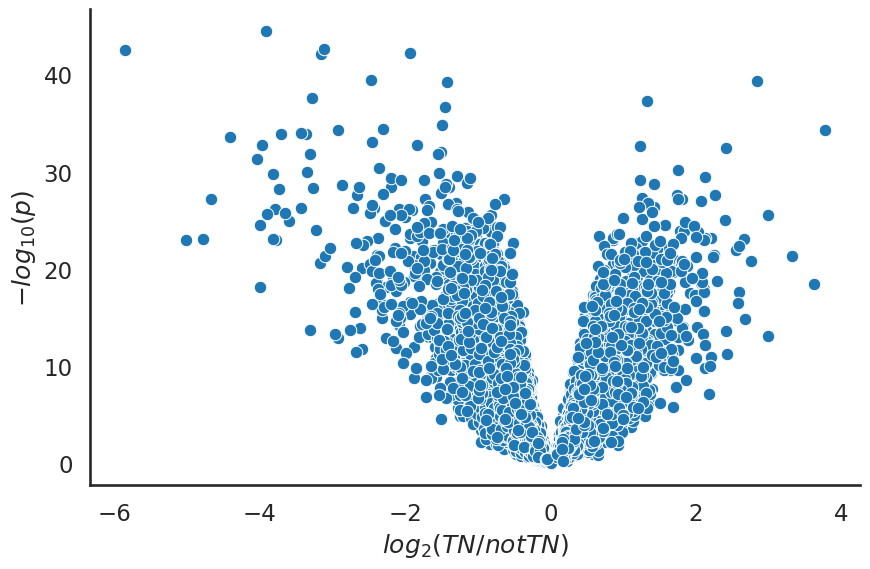

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("talk")
ax = sns.relplot(data=pvalues,x="log_FC",y="-log_p",aspect=1.5,height=6)
ax.set(xlabel="$log_2(TN/not TN)$", ylabel="$-log_{10}(p)$");

The regular interpretation of a Volcano plot is that the ges in the top left and the top right corner are the most interesting ones, as the have a large fold change between the conditions as well as being very significant.